In [1]:
# Run metatrain algorithm randomly picking tasks, one iteration of SLBO.

In [2]:
import utils2

In [3]:
r = utils2.load(672678, reload=False)

Skipping Load
Reading lines
Read lines


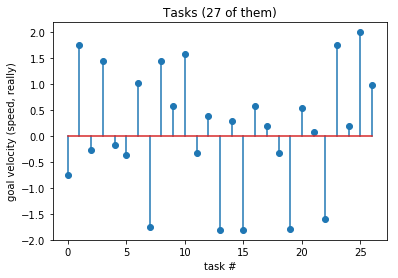

In [4]:
r.plot_tasks()

In [ ]:
# MAP: 670913 = warmup iters 80, slbo = 1, 
# MAP: 671006 = warmup iters 30, slbo = 1,
# MAP: 671012 = warmup iters 30, slbo = 2,

In [ ]:
jobs = [
    670913,
    671006,
    671012,
]

In [ ]:
remotepaths = [f"/tiger/u/lando/cmeta/{job}/log.json" for job in jobs]
localpaths = [f"/tmp/log{job}.json" for job in jobs]

In [ ]:
# buffer
reload = False

In [ ]:
import os

if reload:
    for (i, job) in enumerate(jobs):
        command = f"scp lando@sc.stanford.edu:{remotepaths[i]} {localpaths[i]}"
        rcode = os.system(command)
        if rcode != 0:
            print(command)
            raise Exception("Bad Status code")
        print(f"Loaded Job {job}")

In [ ]:
lines = [read_log(localpath) for localpath in localpaths]

In [ ]:
def tasks_from_lines(ls):
    ts = []
    for l in ls:
        if "Task Sampled" in l["fmt"]:
            ts.append(l["args"][0]["goal_velocity"])
    return ts

In [ ]:
tasks = [tasks_from_lines(l) for l in lines]

In [ ]:
warms, slbos = [], []
for (i, line) in enumerate(lines):
    warm, slbo = extract_rewards(line)
    warms.append(warm)
    slbos.append(slbo)
    print(f"Job: {jobs[i]}")
    print(f"\tNum warms {len(warm)}")
    print(f"\tNum slbo {len(slbo)}")

In [ ]:
slbos[0][1][1]

In [ ]:
real_warms, virt_warms, shad_warms, train_losses, dev_losses, grad_norms, timings = [], [], [], [], [], [], []
for (i, line) in enumerate(lines):
    real_warm, virt_warm, shad_warm, train_loss, dev_loss, grad_norm, timing = get_warmups2(line, 0)
    real_warms.append(real_warm)
    virt_warms.append(virt_warm)
    shad_warms.append(shad_warm)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    grad_norms.append(grad_norm)
    timings.append(timing)
    print(f"Job: {jobs[i]}")
    print(f"\tlength of real {len(real_warm)}")
    print(f"\tlength of virt {len(virt_warm)}")
    print(f"\tlength of shad {len(shad_warm)}")
    print(f"\tlength of train {len(train_loss)}")
    print(f"\tlength of dev {len(dev_loss)}")
    print(f"\tlength of grad {len(grad_norm)}")
    print(f"\tlength of timing {len(timing)}")

In [ ]:
x = timings[0][1][0]
y = timings[0][1][1]
d = y - x
d

In [ ]:
d.total_seconds()

In [ ]:
import datetime
MEtimings = []
for l in lines[1]:
    if "[TRPO]" in l["fmt"]:
        t = datetime.datetime.strptime(l["time"], '%Y-%m-%dT%H:%M:%S.%f')
        MEtimings.append(t)

In [ ]:
def plot_a_timing(ts):
    tzero = ts[0]
    secs = [(t - tzero).total_seconds() for t in ts]
    plt.plot(secs, label="TRPO iters", color="blue")    
    plt.legend()
    plt.figure()
    plt.hist(np.diff(np.asarray(secs)), log=True)
    plt.axhline
    plt.axhline(y=50)
    plt.axhline(y=50*40, label="TASKS * SLBOS * TRPOS")
    plt.axhline(y=1, label="1")
    plt.legend()

In [ ]:
def predict_time(warmup_iters, warmup_policy_iters, warmup_eval_times, tasks, slbo_iters, inner_iters, policy_iters):
    return warmup_iters * warmup_policy_iters * 2 + warmup_eval_times * 8 + tasks * 40 + tasks * inner_iters * slbo_iters * policy_iters * 2

In [ ]:
predict_time(80, 40, 80, 50, 1, 40, 40)

In [ ]:
plot_a_timing(MEtimings)

In [ ]:
def plot_timing(jobidx, n):
    if n == 0:
        return
    fig, ax = plt.subplots(figsize=(15, 5))
    ts = timings[jobidx][n]
    tzero = ts[0]
    print(len(ts))
    ts = [t - tzero for t in ts]
    ts = [(t.seconds * 1e6 + t.microseconds)/(1e6) for t in ts]
    plt.plot(ts[:90], label="TRPO iters", color="blue")
    #plt.axhline(y=60, label="1 min", color="grey")
    #plt.axhline(y=60*30, label="1/2 hour", color="green")
    #plt.axhline(y = 60 * 60, label="1 hour", color="red")
    for i in range(2):
        plt.axvline(x=40*i)
    plt.legend()
    plt.axhline(y=20)
    plt.axhline(y=28)
    print(max(np.diff(ts)))
    return ts[len(ts)-1]

x = plot_timing(0, 1)
x/80/40

In [ ]:
for (i, task) in enumerate(tasks):
    plt.stem(task)
    plt.title(f"Job {jobs[i]}")
    plt.figure()

In [ ]:
real_rewards, virt_rewards = [], []
for (i, line) in enumerate(lines):
    real_reward, virt_reward = get_multi_checkpoints(line, includepost=True)
    real_rewards.append(real_reward)
    virt_rewards.append(virt_reward)

In [ ]:
mins = {
    0.1: -233.78927811594411, 
    0.5: -411.35567527732564, 
    0.9: -610.8872788980733, 
    1.1: -710.8872788980734, 
    1.5: -910.8872788980736, 
    1.9: -1110.8872788980734,
}
maxs = {
    0.1: -3.5636334132798204, 
    0.5: -10.710668525449655, 
    0.9: -30.98072317031702, 
    1.1: -44.14465103596886, 
    1.5: -51.02850590038164, 
    1.9: -61.263854017466976
}

avgs = {
    0.1: -10.202044447173503, 
    0.5: -21.142860320736776, 
    0.9: -46.16668517147687, 
    1.1: -66.24972224328671, 
    1.5: -87.42144407053759, 
    1.9: -113.32796903390458, 
    2.0: -137.50432902203622,
}


#### AVERAGED 

maxs = {-2.0: -90.60565689208266, -1.9: -70.67690735370886, -1.5: -42.06956291427862, -1.1: -36.99489419364075, -1.0: -23.743657058369845, -0.9: -21.157800214277188, -0.1: -3.1041742201174394, -0.5: -10.680755730823584, 0.1: -3.4021209446496337, 0.5: -12.323942266246538, 0.9: -23.53198112703673, 1.1: -31.343789461165542, 1.5: -51.21932985927324, 1.9: -63.050301977318384, 2.0: -85.4236675900036}
mins = {-2.0: -993.9190119522864, -1.9: -945.0818382085795, -1.5: -745.0818382085795, -1.1: -546.2446644648728, -1.0: -510.61478664909976, -0.9: -445.43216946165614, -0.1: -187.5039532110764, -0.5: -259.65397607613966, 0.1: -231.2243621688237, 0.5: -410.1003669467948, 0.9: -609.6475634930734, 1.1: -709.6475634930736, 1.5: -909.6475634930736, 1.9: -1109.6475634930734, 2.0: -1160.8872788980732}
avgs = {-2.0: -136.4502250988098, -1.9: -101.15423269038038, -1.5: -73.20949096123613, -1.1: -61.13370977385761, -1.0: -47.087996715423955, -0.9: -35.88038558730979, -0.1: -8.75671650336899, -0.5: -18.677280704086265, 0.1: -9.545282672321349, 0.5: -23.09364493886916, 0.9: -40.610557419984794, 1.1: -50.763872744894364, 1.5: -81.94783046596359, 1.9: -105.55608759237818, 2.0: -137.50432902203622}

In [ ]:
def min_dist(nvel):
    dist = np.inf
    rvel = None
    for vel in avgs:
        d = np.abs(vel - nvel)
        if d < dist:
            dist = d
            rvel = vel
    return rvel

In [ ]:
def est(vals, vel):
    vels = list(vals.keys())
    vels.sort()
    for i in range(1, len(vels)):
        if vel >= vels[i-1] and vel <= vels[i]:
            a, b = vels[i-1], vels[i]
            slope = (vals[b] - vals[a])/ (b - a)
            
            return vals[a] + slope * (vel - a)
    raise Exception("not good")

In [ ]:
est(maxs, -1.95)

In [ ]:
def plot_task_warmup(jobidx, n):
    if n == 0:
        return
    
    fig, ax = plt.subplots(figsize=(15, 5))

    plot_stage(ax, warms[jobidx][n], 80, 40)
    
    length = min(len(real_warms[jobidx][n]), len(virt_warms[jobidx][n]))

    ax.scatter([(i+1)*40 for i in range(0, length)], real_warms[jobidx][n], color="r")
    ax.scatter([(i+1)*40 for i in range(0, length)], virt_warms[jobidx][n], color="y")
    
    taskvel = tasks[jobidx][n]
    ax.axhline(y=est(mins, taskvel), color="yellow", label="min")
    ax.axhline(y=est(maxs, taskvel), color="orange", label="max")
    ax.axhline(y=est(avgs, taskvel), color="green", label="avg")
    ax.set_ylim((-300, 0))
    ax.set_title(f"WARMUP: Task {n}, Velocity: {tasks[jobidx][n]} WARMUPS")
    ax.legend()
    
def plot_task_stages(jobidx, n, ):
    print(f"Task {n}")
    axs = plot_stages(slbos[jobidx][n], 40, 40, ylim=(-300, 0))
    num = len(slbos[jobidx][n])
    if num == 1:
        taskvel = tasks[jobidx][n]
        axs.axhline(y=est(mins, taskvel), color="yellow", label="min")
        axs.axhline(y=est(maxs, taskvel), color="orange", label="max")
        axs.axhline(y=est(avgs, taskvel), color="green", label="avg")
    else:
        for ax in axs:
            taskvel = tasks[jobidx][n]
            ax.axhline(y=est(mins, taskvel), color="yellow", label="min")
            ax.axhline(y=est(maxs, taskvel), color="orange", label="max")
            ax.axhline(y=est(avgs, taskvel), color="green", label="avg")
        
def plot_stage_rewards(jobidx, n):
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax.scatter(np.arange(len(real_rewards[jobidx][n])), real_rewards[jobidx][n], color="r")
    ax.scatter(np.arange(len(virt_rewards[jobidx][n])), virt_rewards[jobidx][n], color="y")
    
    taskvel = tasks[jobidx][n]
    ax.axhline(y=est(mins, taskvel), color="yellow", label="min")
    ax.axhline(y=est(maxs, taskvel), color="orange", label="max")
    ax.axhline(y=est(avgs, taskvel), color="green", label="avg")
    ax.set_ylim((-300, 0))
    ax.set_title(f"Task {n}, Velocity: {tasks[jobidx][n]}, STAGES")

In [ ]:
def plot_warmup_model(jobidx, n):
    if n == 0:
        return
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    plt.scatter(np.arange(len(train_losses[jobidx][n])), train_losses[jobidx][n], label ="train_loss", color="b")
    plt.scatter(np.arange(len(dev_losses[jobidx][n])), dev_losses[jobidx][n], label="dev loss", color="g")
#    plt.plot(grad_norms[jobidx][n])
    plt.legend()
    plt.ylim(0.0, 0.2)
    plt.ylabel("loss")
    plt.xlabel("warmup iter")
    plt.title(f"Task {n} Model Losses"")

In [ ]:
plot_warmup_model(0, 3)

In [ ]:
print(f"This will print > 2 * {len(tasks[0])} plots")
for (i, t) in enumerate(tasks[0]):
    #plot_warmup_model(0, i)
    plot_task_warmup(0, i)
    #plt.figure()
    #plot_task_stages(0, i)
    #plt.figure()
    #plot_stage_rewards(0, i)
    #plt.figure()

In [ ]:
for (i,t) in enumerate(tasks[1]):
    #plot_task(1, i)
    #plot_task_stages(1, i)
    plot_stage_rewards(1, i)

In [ ]:
for (i,t) in enumerate(tasks[2]):
    #plot_task_warmup(2, i)
    #plot_task_stages(2, i)
    plot_stage_rewards(2, i)

In [ ]:
for l in lines[0]:
    if 

In [ ]:
import math
vs = []
for i in range(50):
    u = np.random.uniform(0, 3)
    vs.append(u)

In [ ]:
vs